# When Will X's Next Album Be Released?

## Assumption
* Distance between albums is poisson distributed
* based on https://youtu.be/HTZaoK_h1A8?t=1451

## Progressions
* Time trend in distance between albums

## Data Pull

In [1]:
x = "Bruce_Springsteen"
# x = "Taylor_Swift"
x = "Enter_Shikari"

In [2]:
url = f"https://en.wikipedia.org/wiki/{x}_discography"


dfs = pd.read_html(url)

In [3]:
df = dfs[1]
df.drop(df.tail(1).index, inplace=True)
df.columns = df.columns.droplevel()

try:
    df = df.rename(columns={"Details": "Album details"})
except Exception as e:
    print(e)

In [4]:
df["Release_date"] = pd.to_datetime(
    [
        " ".join(x.split(":")[1].split(" ")[:4]).split("[")[0]
        for x in df["Album details"]
    ]
)
df["album_delta"] = df["Release_date"].diff().dt.days
df["counts"] = 1
df

,Title,Album details,UK[1],UK Rock[2],UKIndie[3],AUS[4],BEL[5],GER[6],IRL[7],JPN[8],NLD[9],SCO[10],US[11],Certifications,Release_date,album_delta,counts
0,Take to the Skies,Released: 19 March 2007 Label: Ambush Reality ...,4,1,1,—,89,93,26,31,—,6,—,BPI: Gold[12],2007-03-19,nan,1
1,Common Dreads,Released: 15 June 2009 Label: Ambush Reality F...,16,—,—,55,94,96,—,77,—,22,—,BPI: Silver[13],2009-06-15,819.00000,1
2,A Flash Flood of Colour,Released: 16 January 2012 Label: Ambush Realit...,4,1,2,32,42,23,69,81,74,3,67,BPI: Silver[13],2012-01-16,945.00000,1
3,The Mindsweep,Released: 19 January 2015 Label: Ambush Realit...,6,2,1,19,68,17,59,142,26,8,166,NaN,2015-01-19,1099.00000,1
4,The Spark[14],Released: 22 September 2017 Label: Ambush Real...,5,2,1,56,68,60,—,—,—,4,—,NaN,2017-09-22,977.00000,1
5,Nothing Is True & Everything Is Possible[15],"Released: 17 April 2020 Label: SO Recordings, ...",2,1,2,—,80,35,—,—,—,2,—,NaN,2020-04-17,938.00000,1


In [5]:
df.index = pd.DatetimeIndex(df["Release_date"])

In [6]:
# dist_dif = df
# date_range = pd.date_range(
#     dist_dif["Release_date"].min(), dist_dif["Release_date"].max()
# )
# dist_dif.index = pd.DatetimeIndex(dist_dif["Release_date"])
# dist_dif = dist_dif.reindex(date_range, fill_value=0)
# dist_dif

## Data Modeling

In [7]:
# dist_dif["counts"].plot(style=".")

### Adapting Coal mining example
https://docs.pymc.io/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters

x = dist_dif["counts"].sum()  # number of events
# lamda =
t = (dist_dif.index.max() - dist_dif.index.min()).days  # rate parameter
x, t

with pm.Model() as album_model:
    rate = pm.Exponential("album_rate", 1)
    albums = pm.Poisson("albums", rate, observed=dist_dif["counts"])

    trace = pm.sample(1000)

pm.traceplot(trace)

cumulative_prob = []
running_prob = 0
for x in dist_dif["counts"]:
    if x == 1:
        running_prob = 0
    else:
        running_prob += trace["album_rate"].mean()

    cumulative_prob.append(running_prob)

dist_dif["prob"] = cumulative_prob

dist_dif["prob"].plot()

### Survival analysis 

In [8]:
pd.datetime.now()

datetime.datetime(2020, 5, 12, 19, 41, 33, 552179)

In [9]:
sdf = df[["album_delta", "counts"]].dropna().reset_index()
sdf.head()

,Release_date,album_delta,counts
0,2009-06-15,819.00000,1
1,2012-01-16,945.00000,1
2,2015-01-19,1099.00000,1
3,2017-09-22,977.00000,1
4,2020-04-17,938.00000,1


In [10]:
since = pd.DataFrame(
    data=[
        [pd.datetime.now()],
        [(pd.datetime.now() - sdf["Release_date"].max()).days],
        [0],
    ]
).T
current_days = (pd.datetime.now() - sdf["Release_date"].max()).days
since.columns = ["Release_date", "album_delta", "counts"]
since
# sdf = pd.concat([sdf, since])
sdf = sdf[sdf["album_delta"] > 0]
sdf

,Release_date,album_delta,counts
0,2009-06-15,819.00000,1
1,2012-01-16,945.00000,1
2,2015-01-19,1099.00000,1
3,2017-09-22,977.00000,1
4,2020-04-17,938.00000,1


n_patients = len(sdf)
patients = np.arange(n_patients)
fig, ax = plt.subplots(figsize=(8, 6))

blue, _, red = sns.color_palette()[:3]

ax.hlines(
    patients[sdf.counts.values == 0],
    0,
    sdf[sdf.counts.values == 0].album_delta,
    color=blue,
    label="Censored",
)

ax.hlines(
    patients[sdf.counts.values == 1],
    0,
    sdf[sdf.counts.values == 1].album_delta,
    color=red,
    label="Uncensored",
)

ax.scatter(
    sdf[sdf.counts.values == 1].album_delta,
    patients[sdf.counts.values == 1],
    color="k",
    zorder=10,
    label="Metastized",
)

ax.set_xlim(left=0)
ax.set_xlabel("Months since mastectomy")
ax.set_yticks([])
ax.set_ylabel("Subject")

ax.set_ylim(-0.25, n_patients + 0.25)

ax.legend(loc="center right")

interval_length = 1
interval_bounds = np.arange(
    0, sdf.album_delta.max() + interval_length + 1, interval_length
)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

last_period = np.floor((sdf.album_delta - 0.01) / interval_length).astype(int)

death = np.zeros((n_patients, n_intervals))
death[patients, last_period] = df.counts

exposure = (
    np.greater_equal.outer(sdf.album_delta, interval_bounds[:-1]) * interval_length
)

exposure.shape

exposure[patients, last_period] = sdf.album_delta - interval_bounds[last_period.values]

SEED = 644567  # from random.org

from theano import tensor as T

with pm.Model() as model:

    lambda0 = pm.Gamma("lambda0", 0.01, 0.01, shape=n_intervals)

    beta = pm.Normal("beta", 0, sigma=1000)

    lambda_ = pm.Deterministic("lambda_", T.outer(T.exp(beta * df.counts), lambda0))
    mu = pm.Deterministic("mu", exposure * lambda_)

    obs = pm.Poisson("obs", mu, observed=death)

n_samples = 100
n_tune = 100

with model:
    trace = pm.sample(n_samples, tune=n_tune, random_seed=SEED)

np.exp(trace["beta"].mean())

pm.plot_posterior(trace, var_names=["beta"], color="#87ceeb")

## Modeling against wait times

https://blog.datank.ai/a-quick-introduction-to-pymc3-and-bayesian-models-part-i-65419bdffcd8

notes

* build gerneative model for possible observations
* build prior distribution for parameters of model

exponential
* memoryless
* single parameter lamda

In [28]:
sdf["album_delta"].to_list()

[819.0, 945.0, 1099.0, 977.0, 938.0]

could  rewrite against https://stats.stackexchange.com/questions/112273/is-there-a-desription-in-the-literature-of-a-normal-hierarchical-model-with-hype#113082 suggestions of priors
use a gamma rather than normal
    * M∼N()  
    * S∼IG()

In [34]:
# adding data
# Adding data. Note the extra parameter “observed” in the wait_times definition.

# We need to remove zeroes or we run into a bug!

with pm.Model() as model:
    mup = 2
    alpha = pm.Exponential("mu", mup) # shape is IG
    sigmap = 50
    beta = pm.Uniform("sigma", upper=sigmap, lower=0) # beta is the rate
    wait_times = pm.Gamma(
        "wait_times", alpha=mu, beta=sigma, observed=sdf["album_delta"].to_list()
    )  # Right here!
    next_wait_time = pm.Normal("next_wait", mu=mu, sigma=sigma)

In [35]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(5000, step=step, tune=5000)

INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:CompoundStep
INFO:pymc3:>Metropolis: [next_wait]
INFO:pymc3:>Metropolis: [sigma]
INFO:pymc3:>Metropolis: [mu]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 40000/40000 [00:23<00:00, 1703.88draws/s]
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


C:\Users\joe\AppData\Local\Continuum\anaconda3\envs\ds1\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\joe\AppData\Local\Continuum\anaconda3\envs\ds1\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\joe\AppData\Local\Continuum\anaconda3\envs\ds1\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F2B0C73C18>,
      dtype=object)

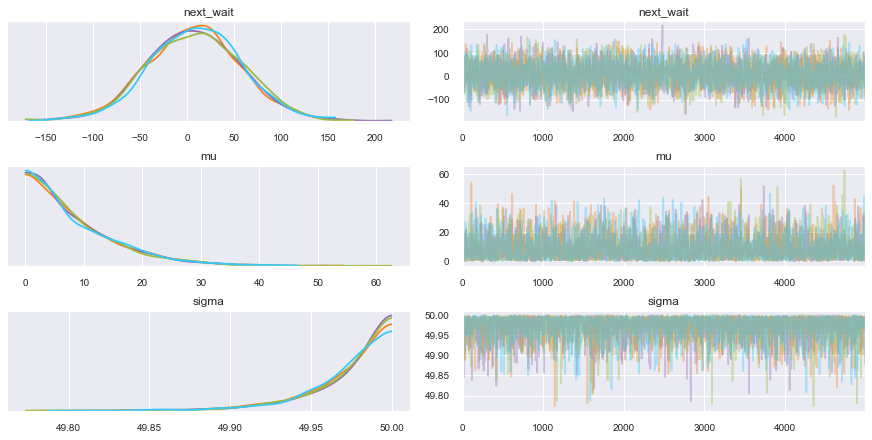

In [36]:
pm.plots.traceplot(trace)

(array([5.500e+01, 3.550e+02, 1.474e+03, 4.390e+03, 5.948e+03, 5.072e+03,
        2.101e+03, 5.260e+02, 7.700e+01, 2.000e+00]),
 array([-171.65575363, -132.76791477,  -93.88007591,  -54.99223705,
         -16.10439818,   22.78344068,   61.67127954,  100.5591184 ,
         139.44695726,  178.33479612,  217.22263498]),
 <a list of 10 Patch objects>)

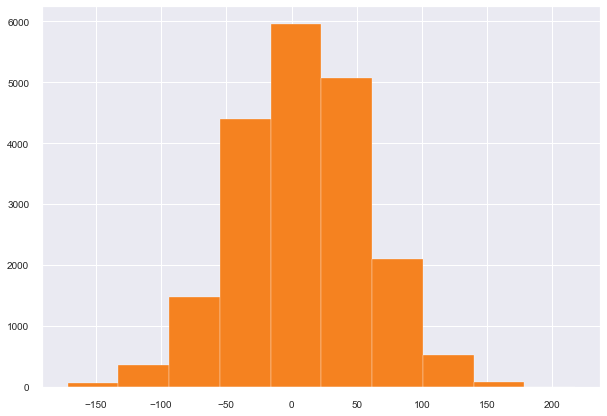

In [37]:
# The posterior distribution for the rate parameter. It encodes the uncertainty about it after observing the data.

plt.figure(figsize=(10, 7))
plt.hist(trace["next_wait"])

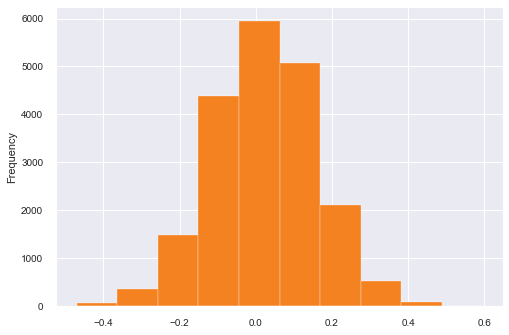

In [38]:
(pd.Series(trace["next_wait"]) / 365).plot.hist()

In [39]:
# How to compute probabilities using the posterior samples.
# We count the number of cases and divide by the total samples drawn.

post_samples = pd.Series(trace["rate"])

print("Expected rate: {}".format(post_samples.mean()))
print(
    "Probability between 0.15 and 0.158: {}".format(
        post_samples.map(lambda x: x > 0.15 and x < 0.158).mean()
    )
)
print(
    "Probability below 0.159: {}".format(post_samples.map(lambda x: x < 0.159).mean())
)

KeyError: 'Unknown variable rate'

In [ ]:
posterior_samples = pm.sample_ppc(model=model, trace=trace, random_seed=4242)[
    "wait_times"
]

In [ ]:
posterior_samples.shape = (posterior_samples.shape[0] * posterior_samples.shape[1],)
posterior_samples = posterior_samples / 365
posterior_samples.shape

In [ ]:
ps = pd.Series(posterior_samples)
print(ps.mean())
print((ps > 10).mean())
print((ps < 1).mean())

In [ ]:
fig, ax = plt.subplots()
ax.hist(posterior_samples, range=(0, 5), bins=30, density=True, label="simulated")
ax.hist(trace["next_wait"], range=(0, 5), bins=30, density=True, label="next wait")


(sdf["album_delta"] / 365).plot.hist(
    density=True, ax=ax, alpha=0.5, title="Years Wait", label="Observed", legend=True
)
ax.legend(["Simulated posterior", "Next wait", "Observed"])
# sns.kdeplot(sdf["album_delta"] / 365, ax=ax)

In [ ]:
posterior_samples = posterior_samples * 365
pm.plots.kdeplot(posterior_samples, cumulative=True)
pm.plots.densityplot(posterior_samples)

In [ ]:
stats = pm.stats.summary(trace["next_wait"]).T.to_dict()["x"]

## Data Prediction

In [ ]:
display(pm.stats.summary(trace["next_wait"]))
display(pm.stats.summary(trace["next_wait"] / 365))

In [ ]:
pm.plots.plot_posterior(trace["next_wait"])

In [ ]:
print("expected wait until next album: ", (trace["next_wait"]).mean() - current_days)
print("expected wait in months: ", ((trace["next_wait"]).mean() - current_days) / 30)
print(
    "but could be up to ",
    stats["hpd_97%"] - current_days,
    " days / ",
    (stats["hpd_97%"] - current_days) / 30,
    " months / ",
    (stats["hpd_97%"] - current_days) / 365,
    " years.",
)